# Contaminate mock with Photometric weight

**author:** Edmond Chaussidon (CEA Saclay)

**mail:** edmond.chaussidon@cea.fr

This notebook explains how to contaminate mocks (and test the efficiency of the method) from photometric weight. The last part needs ``pycorr``. 

We need an acces to `/global/cfs/cdirs/desi/`.

In [1]:
import os
import logging

import fitsio

from regressis import PhotoWeight
from regressis.mocks import create_flag_imaging_systematic
from regressis.utils import setup_logging, setup_mplstyle

setup_logging()
setup_mplstyle() # On NERSC, you may need to load tex with `module load texlive`

logger = logging.getLogger("Notebook")

data_dir = '../regressis/tests/test_data'

In [2]:
%matplotlib inline 

In [3]:
# I/O functions:
def _desi_mock_filename(tracer='LRG', ph=0):
    """Collect the name of DESI Mocks in NERSC."""
    mock_dir='/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/'
    z_dic={'LRG':0.8,'ELG':1.1,'QSO':1.4}
    fname=f'{mock_dir}{tracer}/z{z_dic[tracer]:5.3f}/cutsky_{tracer}_z{z_dic[tracer]:5.3f}_AbacusSummit_base_c000_ph{ph:003d}.fits'
    return fname


def _save_flag(flag, colname, savename):
    """Save flag with a specif colname in .fits file called savename"""
    fits = fitsio.FITS(savename, 'rw', clobber=True) #clobber to overwrite file
    if len(flag) == 1:
        to_save = np.array(flag[0], dtype=[(colname[0], 'bool')])
        fits.write(to_save)
    elif len(flag) == 2:
        fits.write(flag, names=colname)
    fits.close()
    logger.info(f'WRITE flag in {savename}')

In [4]:
# Load photometric weight
wsys = PhotoWeight.load(os.path.join(data_dir, 'SV3_LRG_imaging_weight_256.npy'))

[000001.19] 22-01-17 00:55  PhotoWeight          INFO     Load PhotoWeight class from ../regressis/tests/test_data/SV3_LRG_imaging_weight_256.npy


In [5]:
# Load mock
mock_name = _desi_mock_filename(tracer='LRG', ph=0)
logger.info(f"Read Mock: {mock_name}")
mock = fitsio.FITS(mock_name)[1].read()

# Load high density mock flag
flag_dir = mock_name + '_flags'
logger.info(f"Read Mock flag: {os.path.join(flag_dir, 'pnz.fits')}")
sel_pnz = fitsio.FITS(os.path.join(flag_dir, 'pnz.fits'))[1]['pnz'].read()

[000001.58] 22-01-17 00:55  Notebook             INFO     Read Mock: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
[000004.48] 22-01-17 00:55  Notebook             INFO     Read Mock flag: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits_flags/pnz.fits


----

**Implementation:** Starting from a mock with a higher density than the expected density from data, contamination is done removing objects in each pixel. The quantity of objects to remove is defined by $A$ in $N_{mocks} - A = N_{obs}$. 

Normalizing A by the density of objects in Mocks we have: $A_{norm} = A / N_{mocks}$ and $A_{norm} = 1 - \dfrac{N_{obs}}{N_{mocks}} = 1 - \dfrac{1}{w_{sys}f}$ where $f$ is the ratio between $N_{mocks}$ and $N_{expected}$. Take care $N_{expected}$ is not the same in each photometric footprint. $N_{expected}$ can be estimated from the data !

-----

In [6]:
# Compute flags to build contaminated mock
# Fix the seed for reproductibility
is_in_wsys_footprint, is_for_wsys_cont, pix_number = create_flag_imaging_systematic(mock, sel_pnz, wsys, use_real_density=True, show=False, savedir=None, seed=123)

if False:
    # Save flags in the flag directory (modify '' by flag_dir in os.path.join()
    save_flag([pix_number, is_in_wsys_footprint, is_for_wsys_cont, wsys(pix_number)], ['HPX', 'IS_IN_WSYS', 'IS_FOR_CONT', 'WSYS'], os.path.join('', 'photo_contamination.fits'))

[000007.41] 22-01-17 00:55  Mocks                INFO     Compute the healpix number at nside=256 for each object in the mock
[000017.30] 22-01-17 00:56  Mocks                INFO     Use the real density from PhotoWeight class
[000022.07] 22-01-17 00:56  Mocks                INFO     We remove 76.92% of the objects in the mocks which are in wsys footprint !


-----

## Testing the method !

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from regressis import PhotometricDataFrame, Regression, DR9Footprint
from regressis.utils import build_healpix_map
from regressis.plot import plot_moll
from regressis.systematics import plot_systematic_from_map

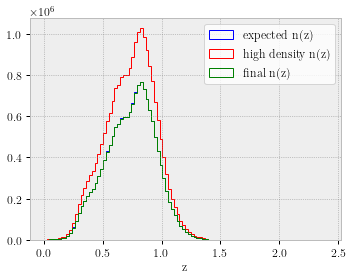

In [8]:
# flag for expected n(z) mock
sel_nz = mock['STATUS'] & 2**0 != 0

plt.figure(figsize=(5, 4))
plt.hist(mock['Z'][sel_nz&is_in_wsys_footprint], histtype='step', bins=100, range=(0.0, 2.4), label='expected n(z)')
plt.hist(mock['Z'][sel_pnz&is_in_wsys_footprint], histtype='step', bins=100, range=(0.0, 2.4), label='high density n(z)')
plt.hist(mock['Z'][is_for_wsys_cont], histtype='step', bins=100, range=(0.0, 2.4), label='final n(z)')
plt.legend()
plt.xlabel('z')
plt.tight_layout()
plt.show()

In [9]:
# Build healpix map:
expected_mock_map = build_healpix_map(256, mock['RA'], mock['DEC'], precomputed_pix=pix_number, sel=sel_nz, in_deg2=True)
high_density_mock_map = build_healpix_map(256, mock['RA'], mock['DEC'], precomputed_pix=pix_number, sel=sel_pnz, in_deg2=True)
cont_mock_map = build_healpix_map(256, mock['RA'], mock['DEC'], precomputed_pix=pix_number, sel=is_for_wsys_cont, in_deg2=True)

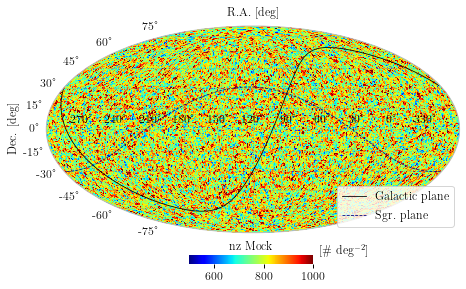

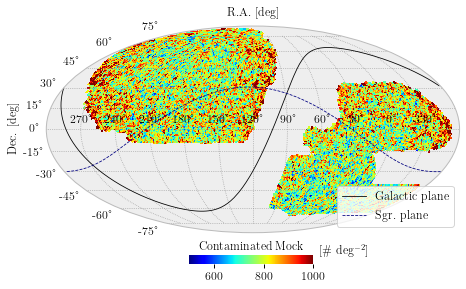

In [10]:
to_plot = expected_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='nz Mock')

to_plot = cont_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Contaminated Mock')

#to_plot = cont_mock_map * wsys.map
#to_plot[to_plot == 0] = np.NaN
#plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Cont + w sys Mock')

In [11]:
# Compute photometric weight from the contaminated mock (cf photometric_mitigation_* notebook for usefull comments)
version, tracer, suffix_tracer = 'MOCKS', 'LRG', '0'

# Load DR9 footprint:
dr9_footprint = DR9Footprint(256, mask_lmc=False, clear_south=True, mask_around_des=True, cut_desi=False)

# Set parameters for the dataframe:
params = dict()
params['data_dir'] = '../regressis/tests/test_data'
params['output_dir'] = None
params['regions'] = ['North', 'South', 'Des']

# Build PhotometricDataFrame class:
dataframe = PhotometricDataFrame(version, tracer, dr9_footprint, suffix_tracer, **params)

# Load features from params['data_dir']:
logger.info('Features')
dataframe.set_features() 

# Load default fracarea (FRACAREA_12290 from features):
logger.info('Targets')
dataframe.set_targets(targets=cont_mock_map)

# Select which pixels will be kept for the training and compute the normalized density on each selected params['regions']:
logger.info('Build')
dataframe.build(cut_fracarea=True)

# Run regression and collect computed weight
regression = Regression(dataframe, regressor='RF', use_kfold=True, n_jobs=6, seed=123)
wsys_new = regression.get_weight(save=False)

[000033.47] 22-01-17 00:56  Footprint            INFO     Load DR9 footprint with mask_lmc=False, clear_south=True, mask_around_des=True and cut_desi=False
[000033.50] 22-01-17 00:56  DataFrame            INFO     version: MOCKS -- tracer: LRG -- regions: ['North', 'South', 'Des']
[000033.50] 22-01-17 00:56  Notebook             INFO     Features
[000033.50] 22-01-17 00:56  DataFrame            INFO     Read ../regressis/tests/test_data/pixweight-dr9-256.fits
[000033.96] 22-01-17 00:56  DataFrame            INFO     Read ../regressis/tests/test_data/sagittarius_stream_256.npy
[000034.04] 22-01-17 00:56  DataFrame            INFO     Sanity check: number of NaNs in features: 0
[000034.05] 22-01-17 00:56  Notebook             INFO     Targets
[000034.05] 22-01-17 00:56  DataFrame            INFO     Do not find corresponding fracarea map --> use FRACAREA_12290 as default fracarea
[000034.05] 22-01-17 00:56  DataFrame            INFO     Read ../regressis/tests/test_data/pixweight-dr9-256

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000038.64] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000038.64] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000038.66] 22-01-17 00:56  Regression           INFO             * 3
[000038.66] 22-01-17 00:56  Regression           INFO               --> There are 80533 pixels to train fold 3 which contains 15796 pixels (kept for the global training)
[000038.66] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000038.73] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000038.73] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000038.75] 22-01-17 00:56  Regression           INFO    

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: Set

[000038.83] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000038.83] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000038.85] 22-01-17 00:56  Regression           INFO             * 5
[000038.86] 22-01-17 00:56  Regression           INFO               --> There are 80680 pixels to train fold 5 which contains 15649 pixels (kept for the global training)
[000038.86] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000038.93] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000038.93] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000038.95] 22-01-17 00:56  Regression           INFO    

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000039.77] 22-01-17 00:56  Regression           INFO       ** South :
[000039.79] 22-01-17 00:56  Regression           INFO         --> Sample size South: 175088 -- Total sample size: 364772 -- Training fraction: 48.00%
[000039.79] 22-01-17 00:56  Regression           INFO         --> Use k-fold training ? True
[000039.79] 22-01-17 00:56  Regression           INFO         --> Engine: LINEAR with params: {}
[000039.82] 22-01-17 00:56  Regression           INFO         --> We use: GroupKFold(n_splits=12) k-fold with group_size = 1000.0
[000039.85] 22-01-17 00:56  Regression           INFO         --> Train and eval for the fold:
[000039.85] 22-01-17 00:56  Regression           INFO             * 0
[000039.86] 22-01-17 00:56  Regression           INFO               --> There are 159490 pixels to train fold 0 which contains 15598 pixels (kept for the global training)
[000039.86] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000040.17] 22-01-17 00:56  Regression           INFO             * 2
[000040.18] 22-01-17 00:56  Regression           INFO               --> There are 160551 pixels to train fold 2 which contains 14537 pixels (kept for the global training)
[000040.18] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000040.28] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000040.28] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000040.31] 22-01-17 00:56  Regression           INFO             * 3
[000040.32] 22-01-17 00:56  Regression           INFO               --> There are 160291 pixels to train fold 3 which contains 14797 pixels (kept for the global training)
[000040.33] 22-01-17 00:56  Regression           INFO               --> All features (e

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000040.46] 22-01-17 00:56  Regression           INFO             * 4
[000040.47] 22-01-17 00:56  Regression           INFO               --> There are 160682 pixels to train fold 4 which contains 14406 pixels (kept for the global training)
[000040.47] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000040.58] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000040.58] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000040.62] 22-01-17 00:56  Regression           INFO             * 5
[000040.63] 22-01-17 00:56  Regression           INFO               --> There are 160630 pixels to train fold 5 which contains 14458 pixels (kept for the global training)
[000040.63] 22-01-17 00:56  Regression           INFO               --> All features (e

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000040.77] 22-01-17 00:56  Regression           INFO             * 6
[000040.78] 22-01-17 00:56  Regression           INFO               --> There are 160749 pixels to train fold 6 which contains 14339 pixels (kept for the global training)
[000040.78] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000040.89] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000040.89] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000040.92] 22-01-17 00:56  Regression           INFO             * 7
[000040.93] 22-01-17 00:56  Regression           INFO               --> There are 160794 pixels to train fold 7 which contains 14294 pixels (kept for the global training)
[000040.93] 22-01-17 00:56  Regression           INFO               --> All features (e

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000041.07] 22-01-17 00:56  Regression           INFO             * 8
[000041.08] 22-01-17 00:56  Regression           INFO               --> There are 160670 pixels to train fold 8 which contains 14418 pixels (kept for the global training)
[000041.08] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000041.19] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000041.19] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000041.22] 22-01-17 00:56  Regression           INFO             * 9
[000041.23] 22-01-17 00:56  Regression           INFO               --> There are 160622 pixels to train fold 9 which contains 14466 pixels (kept for the global training)
[000041.23] 22-01-17 00:56  Regression           INFO               --> All features (e

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000041.36] 22-01-17 00:56  Regression           INFO             * 10
[000041.37] 22-01-17 00:56  Regression           INFO               --> There are 161417 pixels to train fold 10 which contains 13671 pixels (kept for the global training)
[000041.37] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000041.49] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: 0.0000 -- 1.00
[000041.49] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000041.52] 22-01-17 00:56  Regression           INFO             * 11
[000041.53] 22-01-17 00:56  Regression           INFO               --> There are 160449 pixels to train fold 11 which contains 14639 pixels (kept for the global training)
[000041.53] 22-01-17 00:56  Regression           INFO               --> All feature

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[000041.67] 22-01-17 00:56  Regression           INFO         --> Done in: 1.826 s
[000042.54] 22-01-17 00:56  Regression           INFO       ** Des :
[000042.56] 22-01-17 00:56  Regression           INFO         --> Sample size Des: 93355 -- Total sample size: 364772 -- Training fraction: 25.59%
[000042.56] 22-01-17 00:56  Regression           INFO         --> Use k-fold training ? True
[000042.56] 22-01-17 00:56  Regression           INFO         --> Engine: LINEAR with params: {}
[000042.57] 22-01-17 00:56  Regression           INFO         --> We use: GroupKFold(n_splits=6) k-fold with group_size = 1000.0
[000042.59] 22-01-17 00:56  Regression           INFO         --> Train and eval for the fold:
[000042.59] 22-01-17 00:56  Regression           INFO             * 0
[000042.60] 22-01-17 00:56  Regression           INFO               --> There are 77533 pixels to train fold 0 which contains 15822 pixels (kept for the global training)
[000042.60] 22-01-17 00:56  Regression         

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: Set

[000042.87] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: -0.0000 -- 1.00
[000042.87] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000042.89] 22-01-17 00:56  Regression           INFO             * 3
[000042.90] 22-01-17 00:56  Regression           INFO               --> There are 77445 pixels to train fold 3 which contains 15910 pixels (kept for the global training)
[000042.90] 22-01-17 00:56  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000042.96] 22-01-17 00:56  Regression           INFO               --> Mean of mean and std on the fold-training features: -0.0000 -- 1.00
[000042.96] 22-01-17 00:56  Regression           INFO               --> The training is done with sample_weight = 1/np.sqrt(Y_train)
[000042.98] 22-01-17 00:56  Regression           INFO  

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/frame.py:2963: Set

[000043.16] 22-01-17 00:56  Regression           INFO         --> Done in: 0.569 s


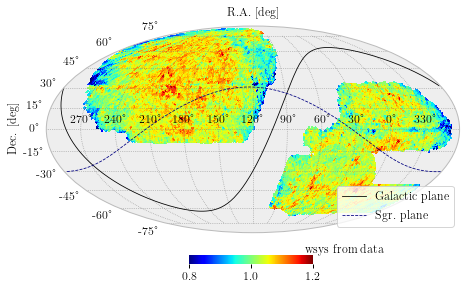

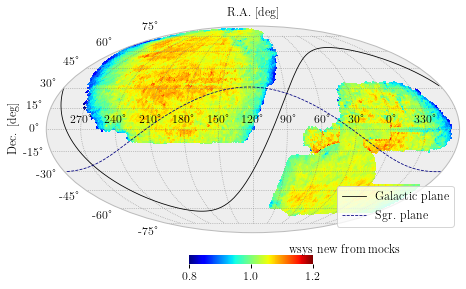

In [12]:
# We compare the weight from data used to contaminated mock and the computed weight from Mock
plot_moll(hp.ud_grade(wsys.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys from data')
plot_moll(hp.ud_grade(wsys_new.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys new from mocks')

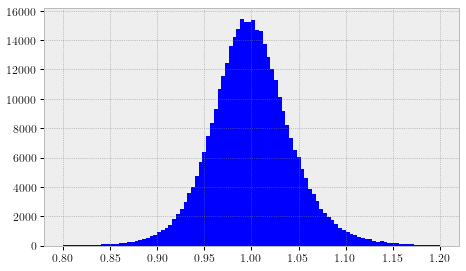

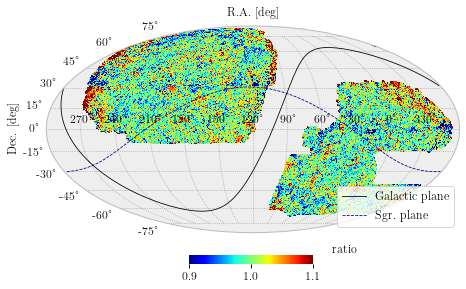

In [13]:
ratio = wsys.map / wsys_new.map 

plt.figure(figsize=(6.55, 4))
plt.hist(ratio, bins=100, range=(0.8, 1.2))
plt.show()

plot_moll(ratio, galactic_plane=True, sgr_plane=True, min=0.9, max=1.1, figsize=(7, 5), label='ratio')

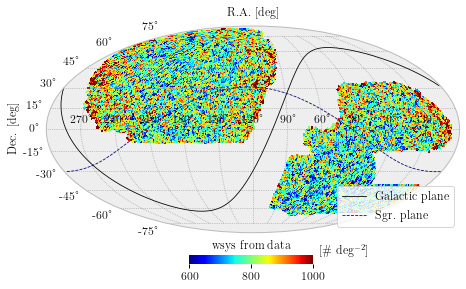

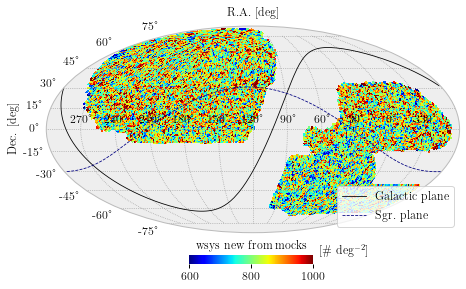

In [14]:
# We compare the weight from data used to contaminated mock and the computed weight from Mock
tmp = dataframe.targets.copy()
tmp[tmp == 0] = np.nan
plot_moll(hp.ud_grade(tmp, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=600, max=1000, figsize=(7, 5), title='wsys from data')
plot_moll(hp.ud_grade(tmp*wsys_new.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=600, max=1000, figsize=(7, 5), title='wsys new from mocks')


The systematic plots computed from real data are available for LRG in img directory

[000054.93] 22-01-17 00:56  Systematics          INFO     Work with North
[000055.73] 22-01-17 00:56  Systematics          INFO     Keep only pixels with fracarea > 0
[000055.73] 22-01-17 00:56  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


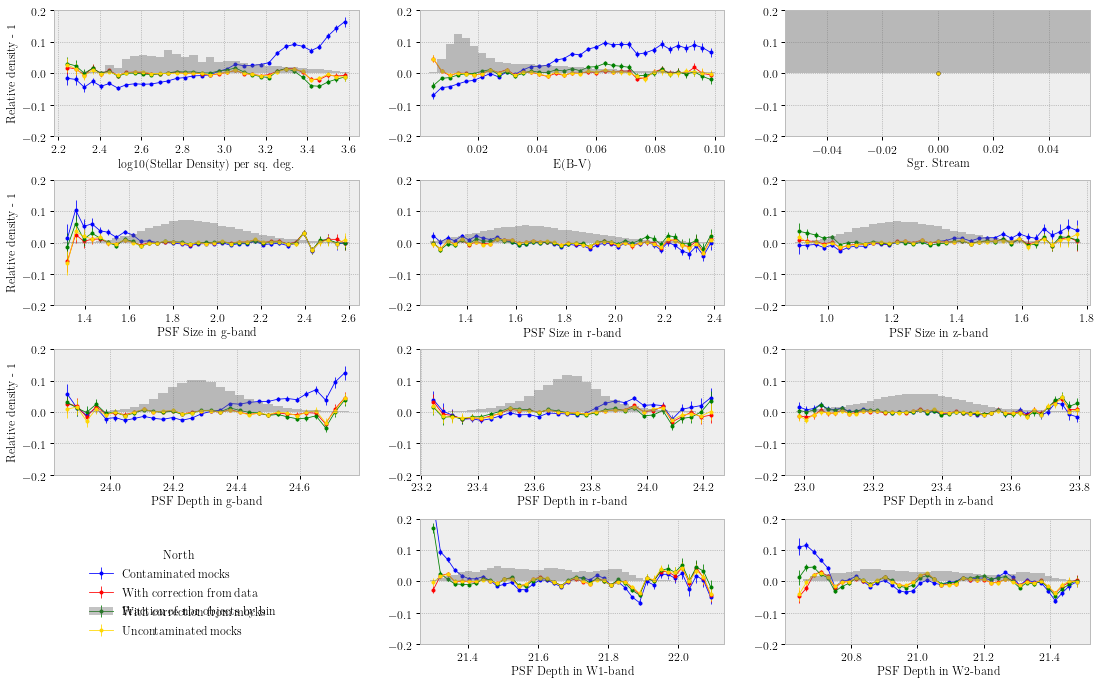

[000059.85] 22-01-17 00:56  Systematics          INFO     Work with South
[000060.76] 22-01-17 00:56  Systematics          INFO     Keep only pixels with fracarea > 0
[000060.76] 22-01-17 00:56  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


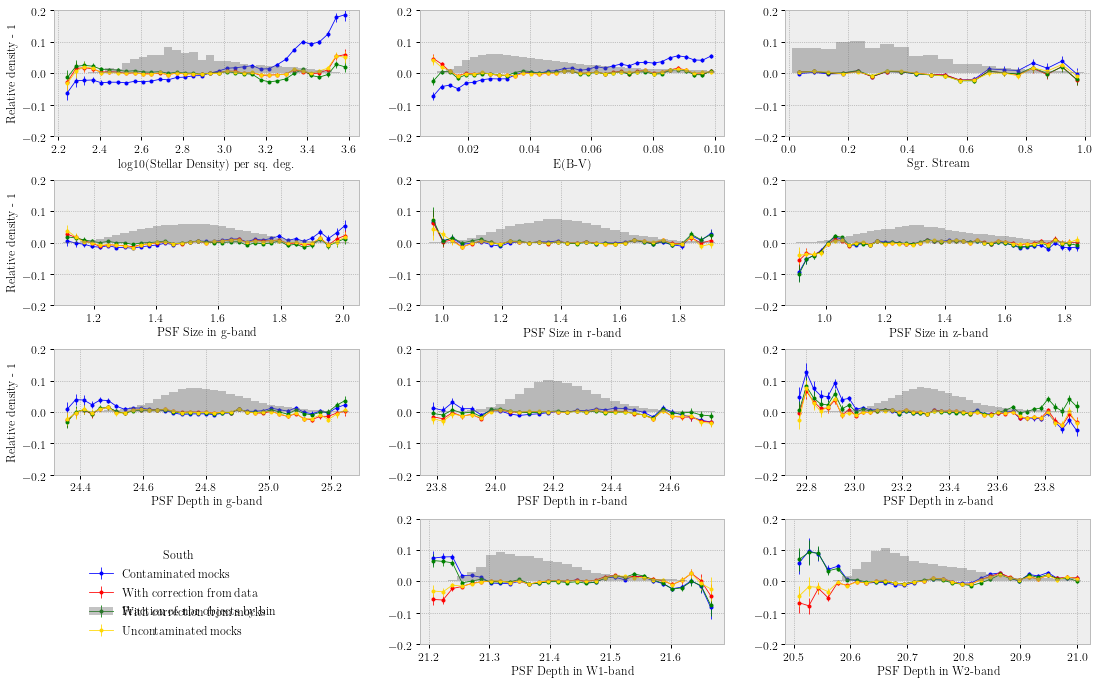

[000065.81] 22-01-17 00:56  Systematics          INFO     Work with Des
[000066.60] 22-01-17 00:56  Systematics          INFO     Keep only pixels with fracarea > 0
[000066.60] 22-01-17 00:56  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


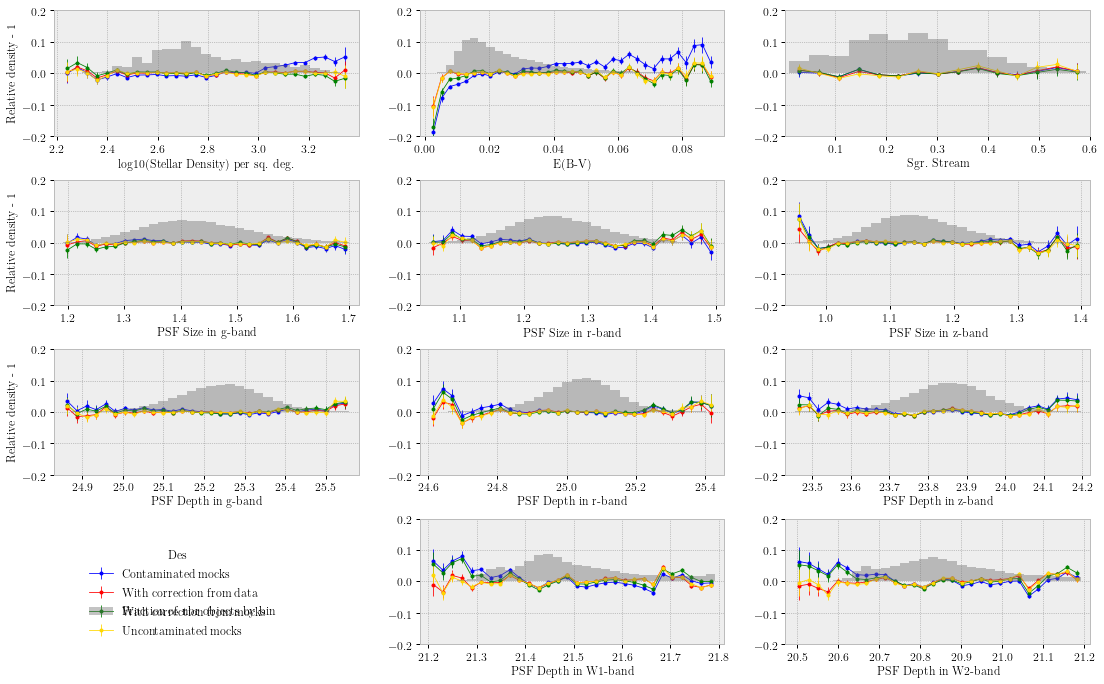

In [15]:
# Systematic plots

print("\nThe systematic plots computed from real data are available for LRG in img directory\n")

plot_systematic_from_map([dataframe.targets, dataframe.targets*wsys.map, dataframe.targets*wsys_new.map, expected_mock_map], 
                         ['Contaminated mocks', 'With correction from data', 'With correction from mocks', 'Uncontaminated mocks'], 
                          dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                          ax_lim=0.2, cut_fracarea=True, limits_fracarea=(0.9, 1.1), show=True, save=False)

[000070.72] 22-01-17 00:57  Systematics          INFO     Work with North
[000071.52] 22-01-17 00:57  Systematics          INFO     Keep only pixels with fracarea > 0
[000071.52] 22-01-17 00:57  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


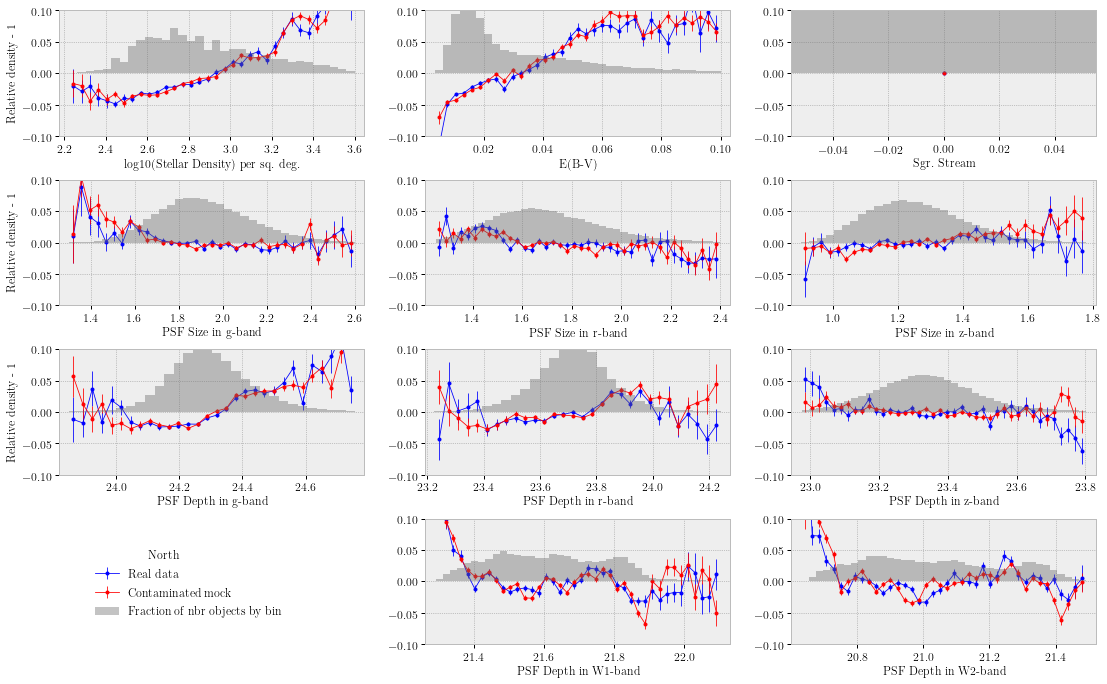

[000075.12] 22-01-17 00:57  Systematics          INFO     Work with South
[000075.98] 22-01-17 00:57  Systematics          INFO     Keep only pixels with fracarea > 0
[000075.98] 22-01-17 00:57  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


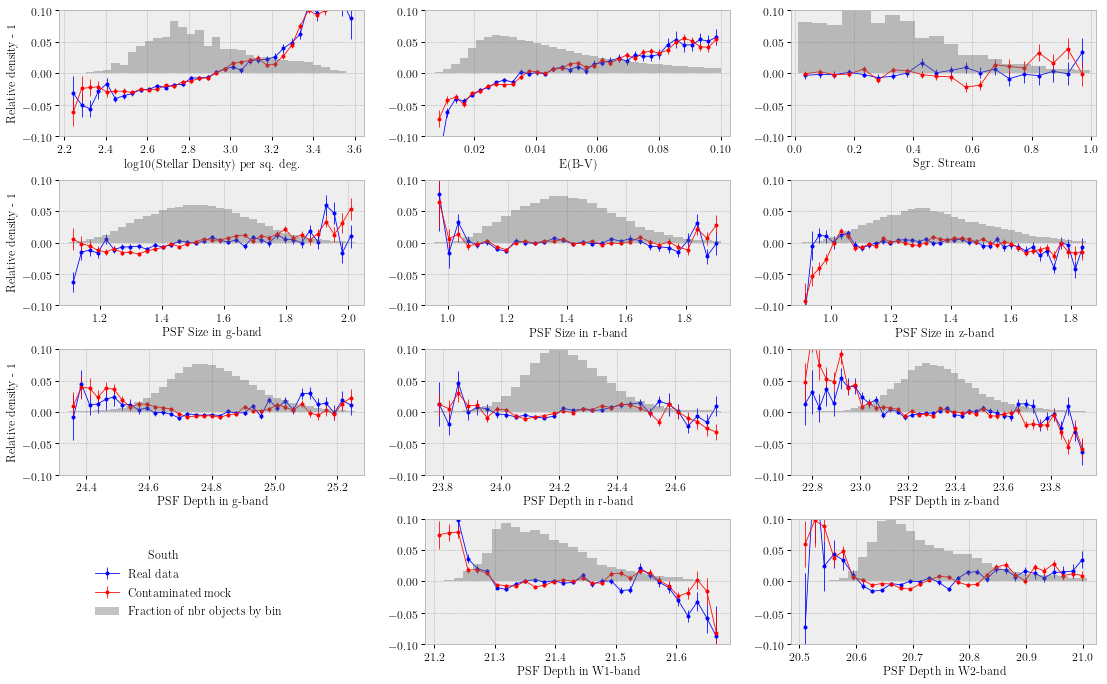

[000079.72] 22-01-17 00:57  Systematics          INFO     Work with Des
[000080.55] 22-01-17 00:57  Systematics          INFO     Keep only pixels with fracarea > 0
[000080.55] 22-01-17 00:57  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


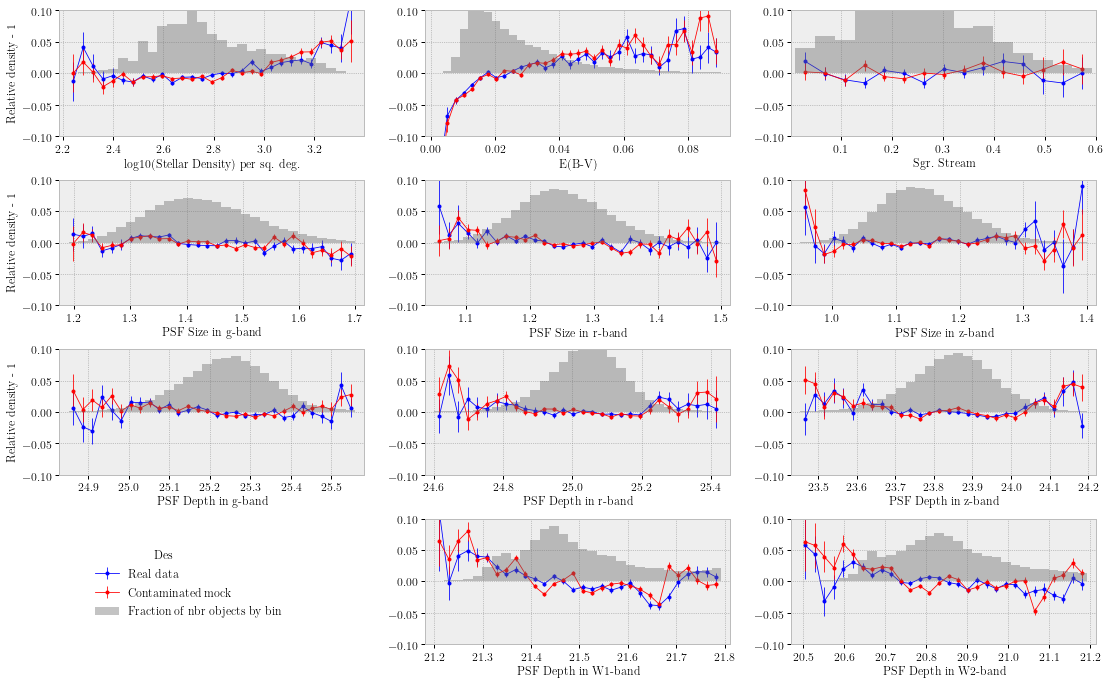

In [16]:
# Compare real data to contaminated mock:

data_map = np.load(os.path.join(data_dir, 'SV3_LRG_256.npy'))

plot_systematic_from_map([data_map, dataframe.targets], 
                         ['Real data', 'Contaminated mock'], 
                          dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                          ax_lim=0.1, cut_fracarea=True, limits_fracarea=(0.9, 1.1), show=True, save=False)

-----

## Compute angular correlation function:

Requirements: pycorr (https://github.com/cosmodesi/pycorr) (installation is straight forward following the doc.)

In [17]:
from pycorr import TwoPointCorrelationFunction, LandySzalayTwoPointEstimator, KMeansSubsampler

In [44]:
def get_ra_dec(nside):
    ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)
    return ra, dec

def compute_angular_correlation(pix_data, pix_randoms, ra_pix, dec_pix, pix_selected, suffixe, n_jackniffe=40, sys_weight_map=None, edges=None, return_result=False, return_plot=False, save_result=False):    
    if edges is None:
        logger.info('Use default edges: np.geomspace(1e-1, 10, 25)')
        edges = np.geomspace(1e-1, 10, 25)
        
    if sys_weight_map is not None:
        logger.info('Apply systematic weights')
        pix_data_weight = pix_data*sys_weight_map
    else:
        pix_data_weight = pix_data
        
        
    if n_jackniffe is not None:
        # for the Jackniffe errors: Initialize KMeansSubsampler with data or random positions -> should have no impact.
        subsampler = KMeansSubsampler(mode='angular', positions=[ra_pix[pix_selected], dec_pix[pix_selected]], nsamples=n_jackniffe, nside=512, random_state=42, position_type='rd')
        data_labels = randoms_labels = subsampler.label([ra_pix[pix_selected], dec_pix[pix_selected]])
    else:
        data_labels = randoms_labels = None
        
    import time
    start = time.time()
    
    result = TwoPointCorrelationFunction('theta', edges, 
                                         data_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         data_weights1=pix_data_weight[pix_selected], 
                                         data_samples1=data_labels,
                                         randoms_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         randoms_weights1=pix_randoms[pix_selected], 
                                         randoms_samples1=randoms_labels,
                                         engine='corrfunc', nthreads=48)
    
    print(f"It takes: {time.time()-start}")
    
    if save_result:
        output = f'PYCORR/LRG_{suffixe}.npy'
        result.save(output)
    
    if return_result:
        return result
    
    if return_plot:
        return result.sep, result.corr, np.diag(result.cov())**0.5

In [19]:
nside_corr = 256

# footprint at correct nside
DR9 = DR9Footprint(nside=nside_corr, mask_lmc=False, clear_south=True, mask_around_des=True, cut_desi=False)

# build ra, dec position of the each pixel
ra_pix, dec_pix = get_ra_dec(nside_corr)

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
logger.info(f'Load randoms: {randoms_path}')
randoms = fitsio.FITS(randoms_path)[1].read()
logger.info('Build random healpix map...')
randoms_pix = build_healpix_map(nside_corr, randoms['RA'], randoms['DEC'])

logger.info('Build uncontaminated mock healpix map...')
mock_pix = build_healpix_map(nside_corr, mock['RA'], mock['DEC'], sel=sel_nz&is_in_wsys_footprint)
logger.info('Build contaminated mock healpix map...')
mock_cont_pix = build_healpix_map(nside_corr, mock['RA'], mock['DEC'], sel=is_for_wsys_cont)

wsys_pix = hp.ud_grade(wsys_new.map, nside_corr, order_in='nested')
wsys_for_cont_pix = hp.ud_grade(wsys.map, nside_corr, order_in='nested')

[000083.87] 22-01-17 00:57  Footprint            INFO     Load DR9 footprint with mask_lmc=False, clear_south=True, mask_around_des=True and cut_desi=False
[000083.94] 22-01-17 00:57  Notebook             INFO     Load randoms: /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits
[000086.72] 22-01-17 00:57  Notebook             INFO     Build random healpix map...
[000097.64] 22-01-17 00:57  Notebook             INFO     Build uncontaminated mock healpix map...
[000099.95] 22-01-17 00:57  Notebook             INFO     Build contaminated mock healpix map...


[000102.58] 22-01-17 00:57  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000110.91] 22-01-17 00:57  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000110.92] 22-01-17 00:57  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000138.58] 22-01-17 00:58  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000193.14] 22-01-17 00:59  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000220.97] 22-01-17 00:59  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000229.57] 22-01-17 00:59  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000229.57] 22-01-17 00:59  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000257.44] 22-01-17 01:00  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000313.61] 22-01-17 01:01  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000342.66] 22-01-17 01:01  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000342.66] 22-01-17 01:01  Notebook             INFO     Apply systematic weights
[000351.17] 22-01-17 01:01  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000351.17] 22-01-17 01:01  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000378.83] 22-01-17 01:02  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000434.12] 22-01-17 01:03  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000462.85] 22-01-17 01:03  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000462.85] 22-01-17 01:03  Notebook             INFO     Apply systematic weights
[000471.29] 22-01-17 01:03  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000471.29] 22-01-17 01:03  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000499.79] 22-01-17 01:04  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000554.63] 22-01-17 01:05  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000583.07] 22-01-17 01:05  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000594.34] 22-01-17 01:05  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000594.34] 22-01-17 01:05  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000634.85] 22-01-17 01:06  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000716.91] 22-01-17 01:07  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000758.88] 22-01-17 01:08  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000769.85] 22-01-17 01:08  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000769.86] 22-01-17 01:08  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000811.38] 22-01-17 01:09  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[000893.88] 22-01-17 01:10  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[000935.16] 22-01-17 01:11  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[000935.16] 22-01-17 01:11  Notebook             INFO     Apply systematic weights
[000945.93] 22-01-17 01:11  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[000945.94] 22-01-17 01:11  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000987.37] 22-01-17 01:12  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001069.65] 22-01-17 01:13  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[001111.97] 22-01-17 01:14  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[001111.97] 22-01-17 01:14  Notebook             INFO     Apply systematic weights
[001123.33] 22-01-17 01:14  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[001123.33] 22-01-17 01:14  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001163.97] 22-01-17 01:15  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001245.58] 22-01-17 01:16  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[001287.98] 22-01-17 01:17  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[001294.45] 22-01-17 01:17  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[001294.45] 22-01-17 01:17  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001319.54] 22-01-17 01:17  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001368.46] 22-01-17 01:18  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[001394.16] 22-01-17 01:19  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[001400.98] 22-01-17 01:19  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[001400.98] 22-01-17 01:19  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001425.18] 22-01-17 01:19  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001473.70] 22-01-17 01:20  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[001498.68] 22-01-17 01:20  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[001498.68] 22-01-17 01:20  Notebook             INFO     Apply systematic weights
[001505.21] 22-01-17 01:20  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[001505.21] 22-01-17 01:20  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001529.52] 22-01-17 01:21  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001577.75] 22-01-17 01:22  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


[001603.52] 22-01-17 01:22  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[001603.52] 22-01-17 01:22  Notebook             INFO     Apply systematic weights
[001610.44] 22-01-17 01:22  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[001610.44] 22-01-17 01:22  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[001635.67] 22-01-17 01:23  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[001685.88] 22-01-17 01:23  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:649: RuntimeWarning: invalid value encountered in true_divide
  state['seps'][0] = wsep/state['wcounts']


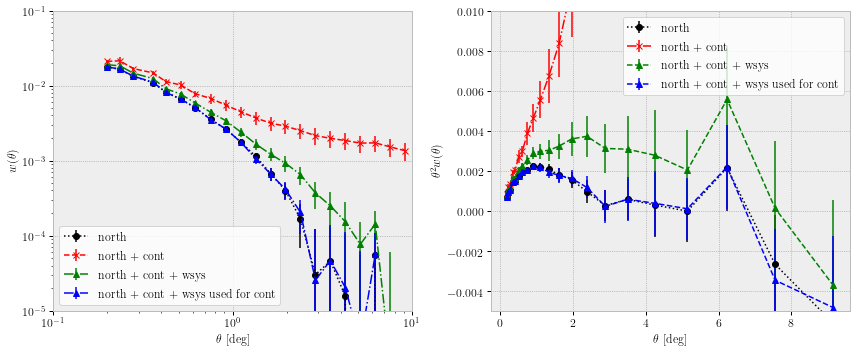

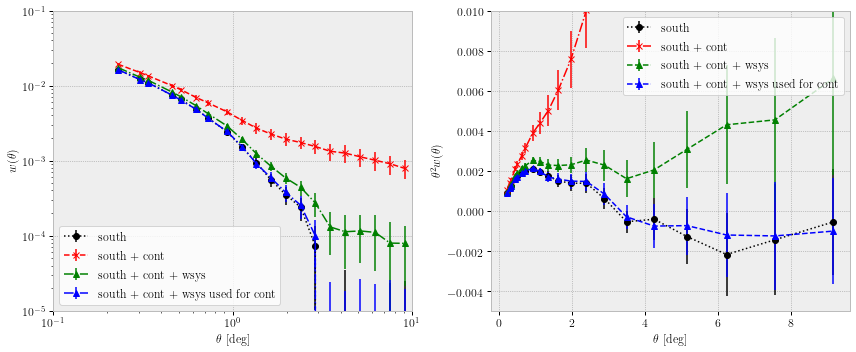

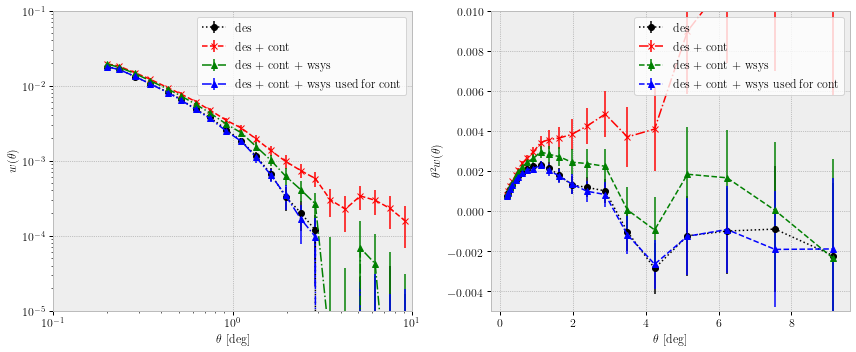

In [20]:
regions = ['north', 'south', 'des']

for i, region in enumerate(regions):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    theta, w, err_w = compute_angular_correlation(mock_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='o', ls=':', c='black', label=region)
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='o', ls=':', c='black', label=region)  
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='x', ls='--', c='red', label=region+' + cont')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='x', ls='-.', c='red', label=region+' + cont')   
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=wsys_pix, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='^', ls='-.', c='green', label=region+' + cont + wsys')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='^', ls='--', c='green', label=region+' + cont + wsys')  
    
    theta, w, err_w = compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=wsys_for_cont_pix, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='^', ls='-.', c='blue', label=region+' + cont + wsys used for cont')
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='^', ls='--', c='blue', label=region+' + cont + wsys used for cont')
    
    ax = axs[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-1, 1e1)
    ax.set_ylim(1e-5, 1e-1)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$w(\theta)$')
    ax.legend()

    ax = axs[1]
    ax.set_ylim(-0.005, 0.01)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\theta^2 w(\theta)$')
    ax.legend()

    fig.tight_layout()

plt.show()

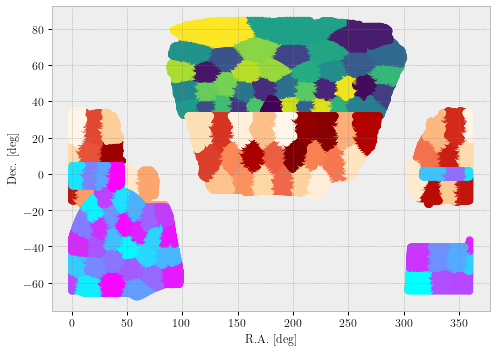

In [40]:
# Draw the patch for jacniffe error estimation:

regions = ['north', 'south', 'des']
cmap = ['viridis', 'OrRd', 'PuBu'] 
plt.figure(figsize=(7, 5))

for i, region in enumerate(regions):
    subsampler = KMeansSubsampler(mode='angular', positions=[ra_pix[DR9(region)], dec_pix[DR9(region)]], nsamples=40, nside=512, random_state=42, position_type='rd')

    plt.scatter(ra_pix[DR9(region)], dec_pix[DR9(region)], c=subsampler.label([ra_pix[DR9(region)], dec_pix[DR9(region)]]), cmap=cmap[i])
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')

plt.tight_layout()
plt.show()

# Comparaison temps jackniffe 

In [ ]:
## et essayer de comparer le temps d'executation avec et sans jackniffe --> noramelment il ne se passe rien ! (mise a part la place memoire car on a juste N_jack histogram de egde quoi (il y a l'histoire du weighting et out il faut encore comprende le papier )

In [49]:
compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, n_jackniffe=20)

[023189.65] 22-01-17 07:22  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[023189.65] 22-01-17 07:22  Notebook             INFO     Apply systematic weights
[023195.80] 22-01-17 07:22  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.utils.JackknifeLandySzalayTwoPointEstimator'>.
[023195.80] 22-01-17 07:22  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[023218.81] 22-01-17 07:22  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.


/global/homes/e/edmondc/.local/lib/python3.8/site-packages/pycorr/twopoint_jackknife.py:500: RuntimeWarning: invalid value encountered in true_divide
  self.sep /= self.wcounts


[023263.99] 22-01-17 07:23  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.
It takes: 90.88274192810059


In [50]:
compute_angular_correlation(mock_cont_pix, randoms_pix, ra_pix, dec_pix, DR9(region), region, sys_weight_map=None, n_jackniffe=None)

[024540.97] 22-01-17 07:44  Notebook             INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[024540.97] 22-01-17 07:44  Notebook             INFO     Apply systematic weights
[024540.98] 22-01-17 07:44  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[024540.98] 22-01-17 07:44  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[024542.33] 22-01-17 07:44  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.
[024545.43] 22-01-17 07:44  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.
It takes: 5.839578151702881
